# Avocado Price Time Series Forecasting

## Imports

In [1]:
from hashlib import sha1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

## Prediction

For the model, we look at the [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices) to forcast average avocado price for the next week. 

In [2]:
df = pd.read_csv("data/avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
df.shape

(18249, 13)

In [4]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [5]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. We split the data so that we have 6 months of test data.

In [6]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]



### Multiple Time Series

In this dataset, there are different measurements for each region. 

We want you to consider this for the avocado prices dataset. For which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

Examining the dataset, we have to separate measurements for type and region as the same Date is used for each combination of type and region. 

In [7]:
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   Total Volume  18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   Total Bags    18249 non-null  float64       
 7   Small Bags    18249 non-null  float64       
 8   Large Bags    18249 non-null  float64       
 9   XLarge Bags   18249 non-null  float64       
 10  type          18249 non-null  object        
 11  year          18249 non-null  int64         
 12  region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), int64(1), object(2)
memory usage: 1.9+ MB


,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
count,18249,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249,18249.000000,18249
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,54
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conventional,NaN,Albany
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9126,NaN,338
mean,2016-08-13 23:30:43.498273792,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,NaN,2016.147899,NaN
min,2015-01-04 00:00:00,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,2015.000000,NaN
25%,2015-10-25 00:00:00,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,NaN,2015.000000,NaN
50%,2016-08-14 00:00:00,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,NaN,2016.000000,NaN
75%,2017-06-04 00:00:00,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,NaN,2017.000000,NaN
max,2018-03-25 00:00:00,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,NaN,2018.000000,NaN


In [8]:
df.sort_values(by="Date").head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast
51,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago
51,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton
51,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh
51,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise


In [9]:
df.sort_values(by="Date", ascending = False).head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2018-03-25,2.02,13379.77,86.84,5923.16,98.37,7271.40,6881.80,389.60,0.00,organic,2018,RaleighGreensboro
0,2018-03-25,1.34,1774776.77,63905.98,908653.71,843.45,801373.63,774634.09,23833.93,2905.61,conventional,2018,NewYork
0,2018-03-25,1.45,121917.39,1929.39,18391.86,110.05,101486.09,85313.41,16172.68,0.00,organic,2018,Southeast
0,2018-03-25,1.19,450658.34,205952.19,73267.19,4313.11,167125.85,132488.40,31527.74,3109.71,conventional,2018,SouthCarolina
0,2018-03-25,1.40,524265.69,103573.88,149867.07,998.53,269826.21,155866.80,113666.70,292.71,conventional,2018,Seattle


In [10]:
df.sort_values(by=["region", "Date"]).head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
51,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
50,2015-01-11,1.77,1182.56,39.00,305.12,0.00,838.44,838.44,0.00,0.0,organic,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany


<!-- END QUESTION -->

<br><br>

### Measurement Spacing

The measurements are all equally spaced with the time difference being 7 days or a week. The 0 days time frequency shown in the plot is the type counterpart of the region that has the same region and Date value, but different type. 

In [11]:
def plot_time_spacing_distribution(df, region="Albany"):
    """
    Plots the distribution of time spacing for a given region.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame with columns 'Location' and 'Date'.
        region (str): The region (e.g., location) to analyze.
    """
    # Ensure 'Date' is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Filter data for the given region
    region_data = df[df['region'] == region]
    
    if region_data.empty:
        print(f"No data available for region: {region}")
        return
    
    # Calculate time differences
    time_diffs = region_data['Date'].sort_values().diff().dropna()
    
    # Count the frequency of each time difference
    value_counts = time_diffs.value_counts().sort_index()
    
    # Display value counts
    print(f"Time spacing counts for {region}:\n{value_counts}\n")
    
    # Plot the bar chart
    plt.bar(value_counts.index.astype(str), value_counts.values, color='skyblue', edgecolor='black')
    plt.title(f"Time Difference Distribution for {region}")
    plt.xlabel("Time Difference (days)")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Time spacing counts for TotalUS:
Date
0 days    169
7 days    168
Name: count, dtype: int64



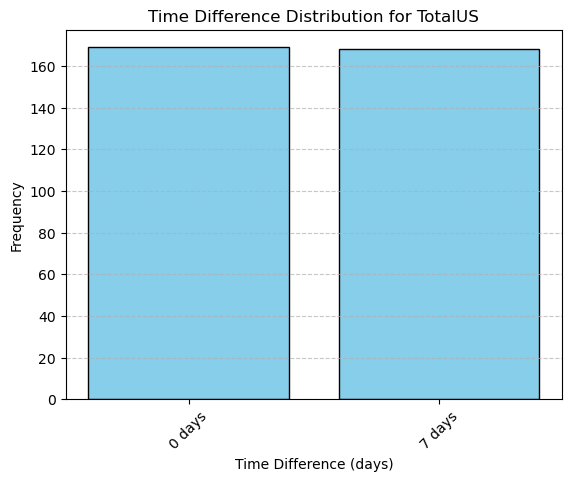

In [12]:
plot_time_spacing_distribution(df, 'TotalUS')

Time spacing counts for Albany:
Date
0 days    169
7 days    168
Name: count, dtype: int64



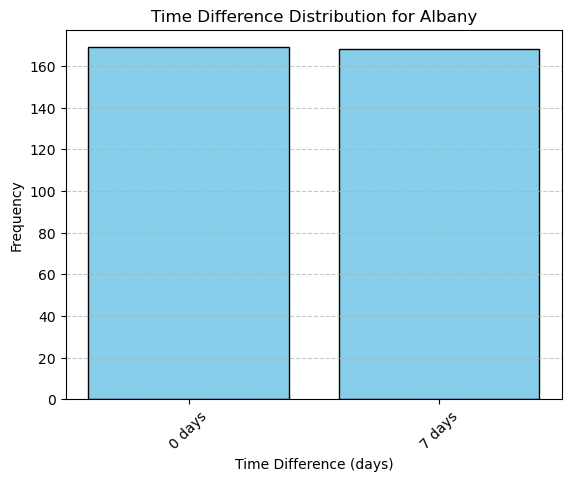

In [13]:
plot_time_spacing_distribution(df, )

<!-- END QUESTION -->

<br><br>

In [14]:
unique_regions = df['region'].unique()
unique_regions

array(['Albany', 'Atlanta', 'BaltimoreWashington', 'Boise', 'Boston',
       'BuffaloRochester', 'California', 'Charlotte', 'Chicago',
       'CincinnatiDayton', 'Columbus', 'DallasFtWorth', 'Denver',
       'Detroit', 'GrandRapids', 'GreatLakes', 'HarrisburgScranton',
       'HartfordSpringfield', 'Houston', 'Indianapolis', 'Jacksonville',
       'LasVegas', 'LosAngeles', 'Louisville', 'MiamiFtLauderdale',
       'Midsouth', 'Nashville', 'NewOrleansMobile', 'NewYork',
       'Northeast', 'NorthernNewEngland', 'Orlando', 'Philadelphia',
       'PhoenixTucson', 'Pittsburgh', 'Plains', 'Portland',
       'RaleighGreensboro', 'RichmondNorfolk', 'Roanoke', 'Sacramento',
       'SanDiego', 'SanFrancisco', 'Seattle', 'SouthCarolina',
       'SouthCentral', 'Southeast', 'Spokane', 'StLouis', 'Syracuse',
       'Tampa', 'TotalUS', 'West', 'WestTexNewMexico'], dtype=object)

The regions are mostly all in distinct states. However, TotalUS covers all of US with much larger values for Total Volume which overlaps other regions.

In [15]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
        
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

In [16]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


In [17]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


We create a lag feature and aim to predict `AveragePriceNextWeek`. 

In [18]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

We look at the train and test splits, specifically for TotalUS. 

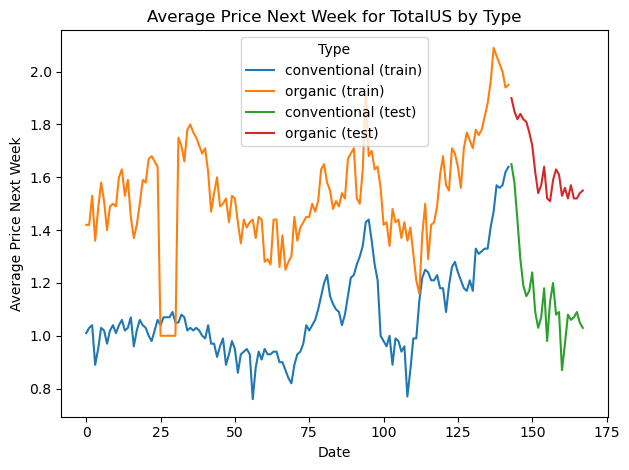

In [19]:
filtered_df = df_train[df_train["region"] == "TotalUS"]


for typ, group_data in filtered_df.groupby('type'):
    plt.plot(range(len(group_data["Date"])), group_data["AveragePriceNextWeek"], label=f"{typ} (train)")

l = len(group_data["Date"])
test_filtered_df = df_test[df_test["region"] == "TotalUS"]             
for typ, group_data in test_filtered_df.groupby('type'):
    plt.plot(range(l, l+len(group_data)), group_data["AveragePriceNextWeek"], label=f"{typ} (test)")

plt.xlabel("Date")
plt.ylabel("Average Price Next Week")
plt.title("Average Price Next Week for TotalUS by Type")
plt.legend(title="Type")
plt.tight_layout()
plt.show()



### Baseline Model

The baseline model uses predicts average price of the current week to be the average price of next week.

0.8285800937261841 $R^2$ for train data, 0.7631780188583048 $R^2$ for test data.

In [20]:
train_r2 = r2_score(df_train["AveragePriceNextWeek"], df_train["AveragePrice"])
train_r2

0.8285800937261841

In [21]:
test_r2 = r2_score(df_test["AveragePriceNextWeek"], df_test["AveragePrice"])
test_r2

0.7631780188583048

### Model Approach

The first approach to encode the date was to use OneHotEncoding on the month for corresponding date, region, and type for categorical features, along with Total Volume, year, and AveragePrice as numerical features. The categorical features were picked based on how logistically, it had a direct effect on the price from analysis and also how a specific time of the year could affect the future price. The numerical features were picked as we felt that they possibly could affect AveragePriceNextWeek depending on the sale volume, and previous average prices. We then added the corresponding season as another feature hoping to capture more of the cyclic trends with categorical instead of numerical features. Adding Season has a minor improvement as there is correlation between month and season, but it was fine to leave it as another feature from encoding the date. The use of polynomial features was also experimented with by adding interaction features between month and year which resulted in a test score of 0.80 and slightly less than other approaches, still similar to other approaches. The coefficients showed that AveragePrice had a lower magnitude and certain polynomial features had impactful coefficients which could mean that AveragePrice has more meaningful and predictive effect compared to other features.

With the dates as categorical variables months and seasons through OneHotEncoding, I decided to use the Ridge linear model and was able to get interpretable coefficient values marking AveragePrice, as an important feature. It is noted that AveragePrice is already a lagged version of the target AveragePriceNextWeek, but we added more lags, AveragePrice_lag which further improved the test score by a little. The Ridge model worked better than using RandomForestRegressor which had signs of overfitting and had a worse test score. The best model had a test score of 0.80 with AveragePrice representing price 7 days ago having a large coefficient. Certain regions also had high magnitude coefficients and the type of avocado clearly showed a direction with organic being +.057248 coefficient and conventional being -0.057252. 

It is noted that the categorical features of type and region have separate measurements for each of the combinations. 

In [22]:
train_df = df_train.assign(
    Month=df_train["Date"].apply(lambda x: x.month_name())
)  # x.month_name() to get the actual string
test_df = df_test.assign(Month=df_test["Date"].apply(lambda x: x.month_name()))

In [23]:

train_df[["Date", "Month"]].sort_values(by="Month")

,Date,Month
1304,2017-04-30,April
9869,2016-04-17,April
9025,2016-04-24,April
3332,2017-04-30,April
3331,2017-04-23,April
...,...,...
11241,2016-09-04,September
11242,2016-09-11,September
11243,2016-09-18,September
11293,2017-09-03,September


In [24]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PolynomialFeatures

#from lecture
def preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features,
    drop_features,
    target, **kwargs
):

    # all_features = set(numeric_features + categorical_features + drop_features + target)
    # if set(train_df.columns) != all_features:
    #     print("Missing columns", set(train_df.columns) - all_features)
    #     print("Extra columns", all_features - set(train_df.columns))
    #     raise Exception("Columns do not match")

    numeric_transformer = make_pipeline(
        SimpleImputer(strategy="median"), StandardScaler()
    )
    categorical_transformer = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    )

    if kwargs:

        poly_preprocessor = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(handle_unknown="ignore", sparse_output=False), kwargs['poly_features'])  # Apply OneHotEncoder to 'Feature1' and 'Feature2'
        ])

        poly_features = PolynomialFeatures(
        interaction_only=True, include_bias=False
        )

        poly_transformer = make_pipeline(poly_preprocessor, poly_features)
            
        preprocessor = make_column_transformer(
            (numeric_transformer, numeric_features),
            (categorical_transformer, categorical_features),
            (poly_transformer, kwargs['poly_features']),
            ("drop", drop_features)
        )

        preprocessor.fit(train_df)
        ohe_feature_names = (
            preprocessor.named_transformers_["pipeline-2"]
            .named_steps["onehotencoder"]
            .get_feature_names_out(categorical_features)
            .tolist()
        )

        month = ["January", "February", "March", "April", "June", "July", "August", "September", "October", "November", "December"]
        year = ["2015", "2016", "2017", "2018"]
        poly_features = month + year
        
        poly_feature_names = (
            preprocessor.named_transformers_["pipeline-3"]
            .named_steps["polynomialfeatures"]
            .get_feature_names_out(poly_features)
            .tolist()
        )
        
        new_columns = numeric_features + ohe_feature_names + poly_feature_names
    else:
        preprocessor = make_column_transformer(
            (numeric_transformer, numeric_features),
            (categorical_transformer, categorical_features),
            ("drop", drop_features)
        )
        
        preprocessor.fit(train_df)
        ohe_feature_names = (
            preprocessor.named_transformers_["pipeline-2"]
            .named_steps["onehotencoder"]
            .get_feature_names_out(categorical_features)
            .tolist()
        )
        new_columns = numeric_features + ohe_feature_names
        
    

    X_train_enc = pd.DataFrame(
        preprocessor.transform(train_df), index=train_df.index, columns=new_columns
    )
    X_test_enc = pd.DataFrame(
         preprocessor.transform(test_df), index=test_df.index, columns=new_columns
    )
    y_train = train_df["AveragePriceNextWeek"]
    y_test = test_df["AveragePriceNextWeek"]

    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

In [25]:
def score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    lr_pipe = make_pipeline(preprocessor, Ridge(max_iter = 1000))
    lr_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(lr_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(lr_pipe.score(test_df, y_test)))
    lr_coef = pd.DataFrame(
        data=lr_pipe.named_steps["ridge"].coef_.flatten(),
        index=X_train_enc.columns,
        columns=["Coef"],
    )
    return lr_coef.sort_values(by="Coef", ascending=False)

In [26]:
drop_features = ["Date", "4046", "4225", "4770", "Small Bags", "Large Bags", "XLarge Bags", "Total Bags"]
numeric_features = ["Total Volume", "AveragePrice"]           
categorical_features = ["type", "region", "year"]
target = ["AveragePriceNextWeek"]

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df, test_df, 
    numeric_features, 
    categorical_features + ["Month"], 
    drop_features,
    target
)
score_lr_print_coeff(preprocessor, train_df, y_train, test_df, y_test, X_train_enc)

Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.311513
region_SanFrancisco,0.106029
region_HartfordSpringfield,0.103423
region_NewYork,0.080540
type_organic,0.060240
...,...
region_LosAngeles,-0.052584
type_conventional,-0.060240
region_SouthCentral,-0.077674
region_DallasFtWorth,-0.080656


In [27]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter = 1000))
lr_pipe.fit(train_df, y_train)
test_r2 = r2_score(y_test, lr_pipe.predict(test_df))
test_r2

0.8012626040633962

In [28]:
#from lecture
def get_season(month):
    SUMMER_MONTHS = ["June", "July", "August"] 
    SPRING_MONTHS = ["March", "April", "May"]
    WINTER_MONTHS = ["December", "January", "February"]
    AUTUMN_MONTHS = ["September", "October", "November"]
    if month in WINTER_MONTHS:
        return "Winter"
    elif month in AUTUMN_MONTHS:
        return "Autumn"
    elif month in SUMMER_MONTHS:
        return "Summer"
    else:
        return "Fall"

In [29]:
train_df = train_df.assign(Season=train_df["Month"].apply(get_season))
test_df = test_df.assign(Season=test_df["Month"].apply(get_season))

In [30]:
drop_features = ["Date", "4046", "4225", "4770", "Small Bags", "Large Bags", "XLarge Bags", "Total Bags"]
numeric_features = ["Total Volume", "AveragePrice"]           
categorical_features = ["type", "region", "year"]
target = ["AveragePriceNextWeek"]

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features,
    categorical_features + ["Month", "Season"],
    drop_features, 
    target
)

In [31]:
coeff_df = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)
coeff_df

Train score: 0.85
Test score: 0.80


,Coef
AveragePrice,0.311505
region_SanFrancisco,0.106038
region_HartfordSpringfield,0.103432
region_NewYork,0.080546
type_organic,0.060245
...,...
region_LosAngeles,-0.052589
type_conventional,-0.060245
region_SouthCentral,-0.077680
region_DallasFtWorth,-0.080662


In [32]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter = 1000))
lr_pipe.fit(train_df, y_train)
test_r2 = r2_score(y_test, lr_pipe.predict(test_df))
test_r2

0.8012592797399395

In [33]:
def score_rf_(preprocessor, train_df, y_train, test_df, y_test, X_train_enc):
    rf_pipe = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=0))
    rf_pipe.fit(train_df, y_train)
    print("Train score: {:.2f}".format(rf_pipe.score(train_df, y_train)))
    print("Test score: {:.2f}".format(rf_pipe.score(test_df, y_test)))


In [34]:
coeff_df = score_rf_(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)
coeff_df

Train score: 0.98
Test score: 0.77


In [35]:
rf_pipe = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100, random_state=0))
rf_pipe.fit(train_df, y_train)
test_r2 = r2_score(y_test, rf_pipe.predict(test_df))
test_r2

0.7651495653647157

In [36]:
#from lecture
def create_past_feature(df, orig_feature, lag, groupby_cols):
    """Creates a new df with a new feature that's a lagged version of the original, where lag is an int.
    df: DataFrame
    orig_feature: str - the original feature to lag
    lag: int - the number of periods to lag
    groupby_cols: list - list of column names to group by (e.g., ['Location', 'Type'])
    """
    new_df = df.copy()
    new_feature_name = "%s_lag%d" % (orig_feature, lag)
    new_df[new_feature_name] = np.nan
    
    # Grouping by multiple columns
    for group_vals, df_group in new_df.groupby(groupby_cols):  
        # Each group (defined by the combination of groupby columns) is its own time series
        new_df.loc[df_group.index[lag:], new_feature_name] = df_group.iloc[:-lag][orig_feature].values
    
    return new_df


In [37]:
train_df = create_past_feature(train_df, "AveragePrice", 1, ['region', 'type'])
test_df = create_past_feature(test_df, "AveragePrice", 1, ['region', 'type'])
train_df = create_past_feature(train_df, "AveragePrice", 2, ['region', 'type'])
test_df = create_past_feature(test_df, "AveragePrice", 2, ['region', 'type'])
train_df = create_past_feature(train_df, "AveragePrice", 3, ['region', 'type'])
test_df = create_past_feature(test_df, "AveragePrice", 3, ['region', 'type'])

In [38]:
drop_features = ["Date", "4046", "4225", "4770", "Small Bags", "Large Bags", "XLarge Bags", "Total Bags"]
numeric_features = ["Total Volume", "AveragePrice"]           
categorical_features = ["type", "region", "year"]
target = ["AveragePriceNextWeek"]

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["AveragePrice_lag1", "AveragePrice_lag2", "AveragePrice_lag3"],
    categorical_features + ["Month", "Season"],
    drop_features, 
    target
    
)

In [39]:
coeff_df = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)
coeff_df

Train score: 0.86
Test score: 0.80


,Coef
AveragePrice,0.235103
region_SanFrancisco,0.064752
region_HartfordSpringfield,0.060631
AveragePrice_lag1,0.049928
region_NewYork,0.047860
...,...
Month_November,-0.034782
type_conventional,-0.036648
region_SouthCentral,-0.048016
region_DallasFtWorth,-0.050079


In [40]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter = 1000))
lr_pipe.fit(train_df, y_train)
test_r2 = r2_score(y_test, lr_pipe.predict(test_df))
test_r2

0.8031734795429905

In [41]:
drop_features = ["Date", "4046", "4225", "4770", "Small Bags", "Large Bags", "XLarge Bags", "Total Bags"]
numeric_features = ["Total Volume", "AveragePrice"]           
categorical_features = ["type", "region", "year"]
target = ["AveragePriceNextWeek"]

X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(
    train_df,
    test_df,
    numeric_features + ["AveragePrice_lag1", "AveragePrice_lag2", "AveragePrice_lag3"],
    categorical_features + ["Season"],
    drop_features, 
    target, 
    poly_features = ["Month", "year"]
)

In [42]:
coeff_df = score_lr_print_coeff(
    preprocessor, train_df, y_train, test_df, y_test, X_train_enc
)
coeff_df

Train score: 0.86
Test score: 0.80


,Coef
AveragePrice,0.225607
February 2018,0.071109
region_SanFrancisco,0.070323
region_HartfordSpringfield,0.066302
region_NewYork,0.052225
...,...
December 2016,-0.044056
June 2018,-0.049718
region_SouthCentral,-0.052318
region_DallasFtWorth,-0.054366


In [43]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter = 1000))
lr_pipe.fit(train_df, y_train)
test_r2 = r2_score(y_test, lr_pipe.predict(test_df))
test_r2

0.800104685729728